
##  10 Academy Weekly Challenge: Week 6


# Bank Institution Term Deposit Predictive Model

The Bank of Portugal collected a huge amount of data that includes customers profiles of those who have to subscribe to term deposits and the ones who did not subscribe to a term deposit. This work focuses on developing a robust predictive model that would help the bank identify customers who would or would not subscribe to their term deposit in the future.


The dataset used in this notebook can be downloaded from the [UCI ML]( http://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

This notebook consists of the following sections
- data cleaning and feature extraction
- developing models and testing their accuracy

## Data cleaning and Feature extraction

**The first step is to import all the necessary libraries to be used for cleaning, visualizing, preprocessing, and modelling.**

In [116]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE 
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

In [112]:
#set parameters for matplotlib

%matplotlib inline
rcParams["figure.figsize"] = 16,8

In [137]:
#fetch the dataset from a local directory

data = pd.read_csv("../datasource/bank-additional-full.csv", sep = ";")
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


**Important note:**  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**As specified on the description of the data source above, the <code>duration</code> column is safely dropped.**

In [31]:
#drop the "duration" column
data.drop("duration", axis = 1, inplace=True)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

**A feature correlation analysis is performed to identify highly correlated columns and take measures**

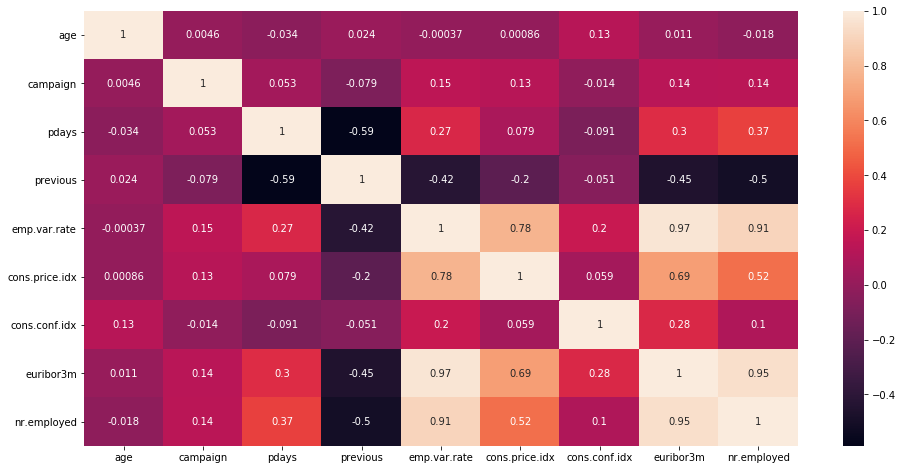

In [33]:
#get correlation of numeric features
correlation = data.corr()

#visualize the correlation using heatmap
sns.heatmap(correlation, annot=True)

**From the above heatmap, it can be observed that <code>euribor3m</code> column has a very high correlation with <code>emp.var.rate</code> and <code>nr.employed</code> columns. As a general rule, features having a correlation values of 0.6 and above should be seriously considered to be dropped. Therefore, <code>euribor3m</code> and <code>emp.var.rate</code> are safely dropped.**

In [34]:
#drop "emp.var.rate" and "euribor3m" columns
data.drop("emp.var.rate", axis = 1, inplace = True)
data.drop("euribor3m", axis = 1, inplace = True)

In [35]:
# def get_numeric_cols(df):
#     numerical_columns = []
#     for i in df.columns:
#         dtype = df[i].dtype
#         if (dtype == "int64") | (dtype == "float64"):
#             numerical_columns.append(i)
#     return numerical_columns

# def get_catagorical_cols(df):
#     catagorical_columns = []
#     for i in df.columns:
#         dtype = df[i].dtype
#         if (dtype == "O"):
#             catagorical_columns.append(i)
#     return catagorical_columns

**Next, numeric features are checked for outliers using boxplots.**

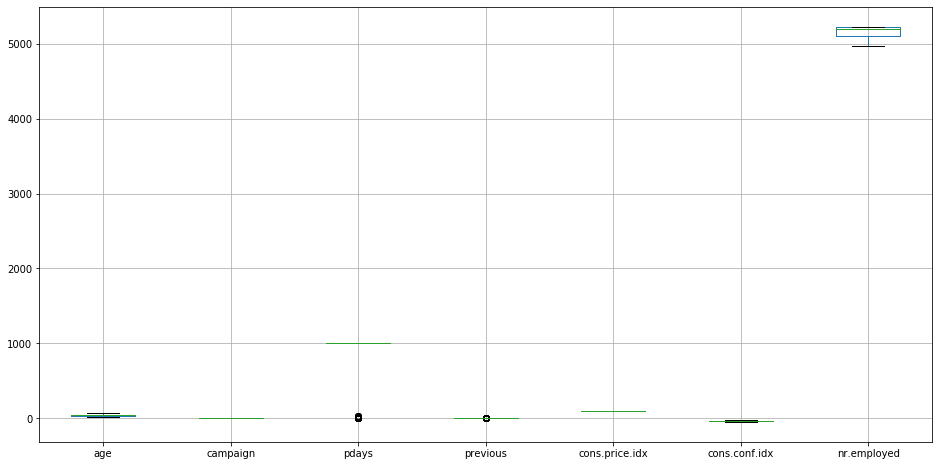

In [119]:
#boxplots of numeric features 
data.boxplot()


{'whiskers': [<matplotlib.lines.Line2D at 0x7fbb647b2390>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbb647b2dd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbb632b3ed0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fbb647a4850>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fbb647a4d50>],
 'means': []}

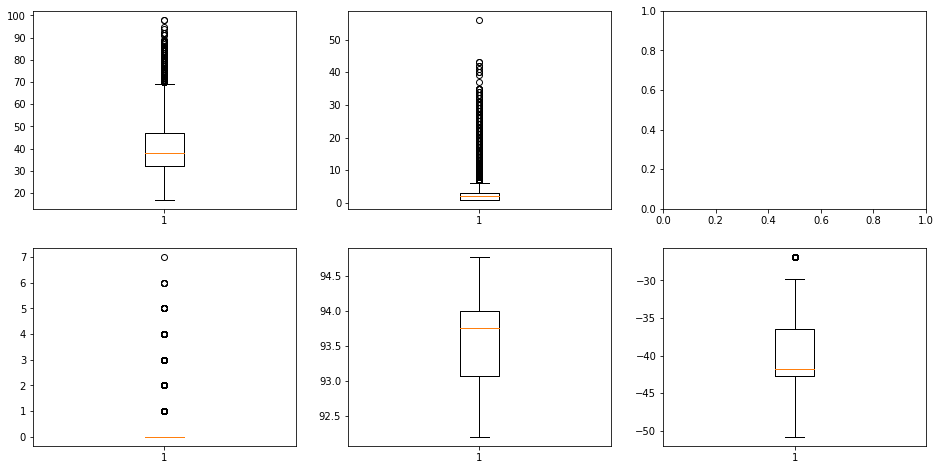

In [143]:
fig, ((ax1, ax2, axe3), (ax4, ax5,ax6)) = plt.subplots(2, 3)
ax1.boxplot(data.age)
ax2.boxplot(data.campaign)
ax3.boxplot(data.pdays)
ax4.boxplot(data.previous)
ax5.boxplot(data["cons.price.idx"])
ax6.boxplot(data["cons.conf.idx"])
# ax7.boxplot(data.previous)

**Outliers are removed using Inter Quartile Range (IQR) method.**

In [37]:
def remove_outliers(df, col): 

    ''' returns the dataframe with the outliers removed by calculating the IQR for the feature and 
    filtering the dataframe to be within that range'''

    Q1 = col.quantile(0.25)       #get the 1st quartile
    Q3 = col.quantile(0.75)       #get the 3rd quartile
    IQR = Q3 - Q1                 #get the inter quartile range
    upper_limit = Q3 + 1.5*IQR    #set the upper limit
    lower_limit = Q1 - 1.5*IQR    #set the lower limit
    df = df[(col>lower_limit) & (col<upper_limit)]  #filter the dataframe to be in the IQR
    
    return df

**The IQR method is applied to "age","campaign" and "cons.conf.idx" to remove the outliers. Although "pdays" and "previous" seem to have outliers, it is just the representation of values that resulted in extreme values.** (For example, 999 in pdays represents no contact to the client.)

In [38]:
#apply the IQR method to remove outliers
data = remove_outliers(data, data.age)
data = remove_outliers(data, data.campaign)
data = remove_outliers(data, data["cons.conf.idx"])

**Next, categorical features are encoded into numeric features using One-hot encoding technique. This can be achieved using Pandas' <code>get_dummies</code> method. This increases the coulumn count drastically.**

In [104]:
#encode categorical features using one-hot encoding
data_encoded = pd.get_dummies(data, drop_first=True)
data_encoded.head()

,age,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y_yes
0,56,1,999,0,93.994,-36.4,5191.0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
1,57,1,999,0,93.994,-36.4,5191.0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,37,1,999,0,93.994,-36.4,5191.0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,40,1,999,0,93.994,-36.4,5191.0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,56,1,999,0,93.994,-36.4,5191.0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


**Now that the features are encoded, The data can be split into training and test sets using sklearn's <code>train_test_split</code> method**

In [105]:
#split the dataset into 10% test and 90% training sets.
train, test = train_test_split(data_encoded, test_size=0.1, train_size=0.9, random_state=1)

**Next we check if our data set is balanced or not by plotting the positive and negative target values.**

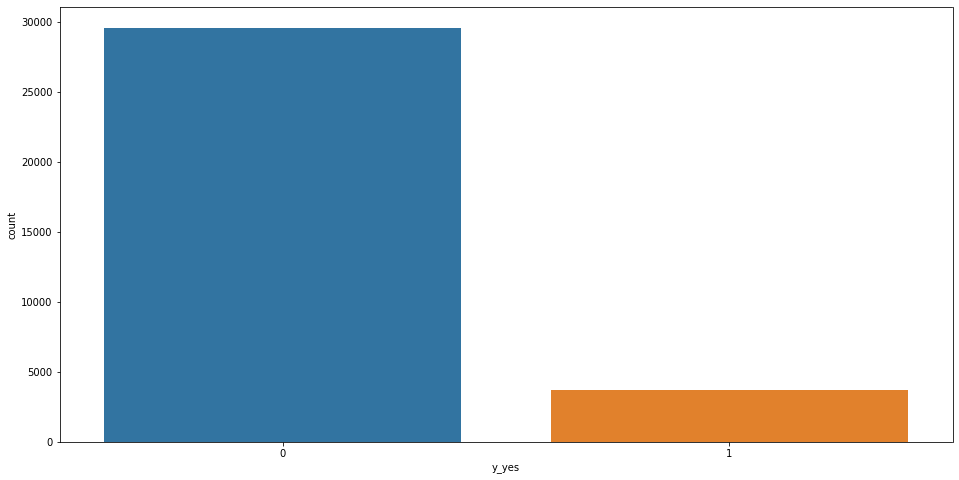

In [41]:
#plot the count of yes values to check for class imbalance
sns.countplot(train.y_yes)

**A significant class imbalance can be observed from the plot. We can handle this imbalance by upsampling the minority class to be the same number as the majority class.**  

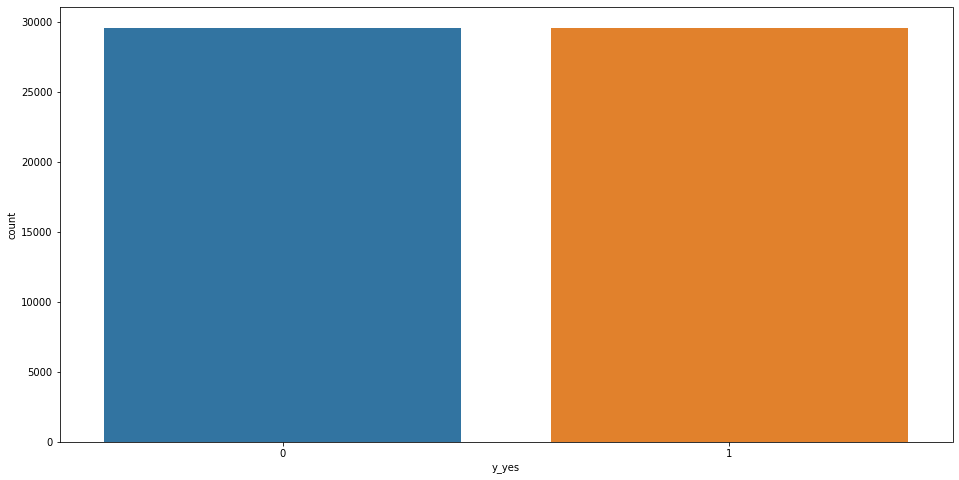

In [42]:
#get the classes
yes = train[train.y_yes==1]
no = train[train.y_yes==0]

# upsample minority
upsampled = resample(yes,
                          replace=True, # sample with replacement
                          n_samples=len(no), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
train = pd.concat([no, upsampled])

# check new class counts
sns.countplot(train.y_yes)

**Next the predictor and target features are separated for both the training and test sets.**

In [44]:
#take all but the last feature as a predictor and the last feature as a target training set
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]

#take all but the last feature as a predictor and the last feature as a target for the test set
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

**Next both the training and test sets are scaled using sklearn's <code>MinMaxScaler</code>**

In [45]:
#Scalling training and test sets to be between 0 and 1
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

**Below t-SNE dimensionality reduction technique is used to reduce the features into three principal components**

In [46]:
#reduce the dimension into three components using t-SNE, This technique returns numpy arrays
X_train = TSNE(n_components=3, n_iter=300).fit_transform(X_train)
X_test = TSNE(n_components=3, n_iter=300).fit_transform(X_test)

array([[-0.17968121,  1.1661706 , -1.9865336 ],
       [ 2.512543  ,  0.9879122 , -0.3845421 ],
       [ 2.2477474 , -0.2602041 , -2.1780365 ],
       ...,
       [-3.390942  , -0.27212605,  2.127653  ],
       [-0.6626756 , -1.584702  ,  4.105337  ],
       [ 2.0160923 ,  1.7887299 ,  1.1002009 ]], dtype=float32)

**It can be seen that both sets now have three columns**

In [51]:
#check the shape of the reduced training set
X_train.shape,X_test.shape

((59142, 3), (3697, 3))

**Once again, the reduced sets are converted back into dataframes to be fitted into the models.**

In [103]:
#convert the sets into pandas dataframes
X_train = pd.DataFrame(data=X_train)
X_test = pd.DataFrame(data=X_test)
y_train = pd.DataFrame(data=y_train)
y_test = pd.DataFrame(data=y_test)

## Modeling

**Since the training and test sets are now ready, We can use Stratified K-Fold technique to train our models. We can use accuracy scores as an evaluation metric since our training set has equal number of records belonging to YES and NO classes**

In [98]:
'''returns an array of accuracy scores for the given model.'''
def train_model(classifier):
    accuracy=[]  #initialize accuracy array
    skf = StratifiedKFold(n_splits=10, random_state=None) #initialize the StratifiedKFold with 10 splits
    skf.get_n_splits(X_train, y_train) #get split indexes
    
    for train_index, test_index in skf.split(X_train,y_train): #get the data for each split index
        print("TRAIN:", train_index, "TEST:", test_index)
        X1_train, X1_test = X_train.iloc[train_index], X_train.iloc[test_index] 
        y1_train, y1_test = y_train.iloc[train_index], y_train.iloc[test_index] 

        classifier.fit(X1_train,y1_train) #fit the data into the model
        prediction=classifier.predict(X1_test) #get predictions
        score = metrics.accuracy_score(prediction,y1_test) #get accuracy of the prediction
        accuracy.append(score) #add the accuracy to the list of accuracies
    print("\nAccuracies: ",accuracy)
    print("\nAverage Accuracy =", round(np.array(accuracy).mean()*100,2),"%")
    print("\nMinimum Accuracy =", round(np.array(accuracy).min()*100,2),"%")     
    print("\nMaximum Accuracy =", round(np.array(accuracy).max()*100,2),"%")     

**In this notebook, three classification algorithms are used. These are:**
- Logistic Regression
- XGBoost
- Multilayer Perceptrons

In [99]:
#initialize logistic regression from sklearn
log_regression = LogisticRegression()

#fit the training data into the model and get accuracy scores
train_model(log_regression)


TRAIN: [ 2958  2959  2960 ... 59139 59140 59141] TEST: [    0     1     2 ... 32525 32526 32527]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [ 2958  2959  2960 ... 35483 35484 35485]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [ 5915  5916  5917 ... 38440 38441 38442]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [ 8872  8873  8874 ... 41397 41398 41399]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [11829 11830 11831 ... 44354 44355 44356]


/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d arr

TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [14786 14787 14788 ... 47311 47312 47313]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [17743 17744 17745 ... 50268 50269 50270]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [20700 20701 20702 ... 53225 53226 53227]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [23657 23658 23659 ... 56182 56183 56184]
TRAIN: [    0     1     2 ... 56182 56183 56184] TEST: [26614 26615 26616 ... 59139 59140 59141]

Accuracies:  [0.6113271344040575, 0.6074387151310229, 0.6097396009469056, 0.6107541427122083, 0.6151504903618532, 0.5975650997632735, 0.5911396685830234, 0.602637808589787, 0.6092323300642543, 0.6046668921203923]

Average Accuracy = 60.6 %

Minimum Accuracy = 59.11 %

Maximum Accuracy = 61.52 %


/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d arr

In [100]:
#initialize XGBoost from sklearn
xg_boost = xgb.XGBClassifier()

#fit the data and get accuracy scores
train_model(xg_boost)

TRAIN: [ 2958  2959  2960 ... 59139 59140 59141] TEST: [    0     1     2 ... 32525 32526 32527]


/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [ 2958  2959  2960 ... 35483 35484 35485]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [ 5915  5916  5917 ... 38440 38441 38442]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [ 8872  8873  8874 ... 41397 41398 41399]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [11829 11830 11831 ... 44354 44355 44356]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [14786 14787 14788 ... 47311 47312 47313]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [17743 17744 17745 ... 50268 50269 50270]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [20700 20701 20702 ... 53225 53226 53227]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [23657 23658 23659 ... 56182 56183 56184]
TRAIN: [    0     1     2 ... 56182 56183 56184] TEST: [26614 26615 26616 ... 59139 59140 59141]

Accuracies:  [0.7103972950126797, 0.7027895181741336, 0.7137301318904294, 0.7002029083530605, 0.7149137639499493, 0.7005410889

In [102]:
#initialize Multilayer perceptron classifier from sklearn
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

#fit the data and get accuracy scores
train_model(clf)

TRAIN: [ 2958  2959  2960 ... 59139 59140 59141] TEST: [    0     1     2 ... 32525 32526 32527]


/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [ 2958  2959  2960 ... 35483 35484 35485]


/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [ 5915  5916  5917 ... 38440 38441 38442]
TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [ 8872  8873  8874 ... 41397 41398 41399]


/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [11829 11830 11831 ... 44354 44355 44356]


/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [14786 14787 14788 ... 47311 47312 47313]


/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [17743 17744 17745 ... 50268 50269 50270]


/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [20700 20701 20702 ... 53225 53226 53227]


/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN: [    0     1     2 ... 59139 59140 59141] TEST: [23657 23658 23659 ... 56182 56183 56184]


/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN: [    0     1     2 ... 56182 56183 56184] TEST: [26614 26615 26616 ... 59139 59140 59141]

Accuracies:  [0.6666103127641589, 0.674894336432798, 0.6550557997970916, 0.6665539398038552, 0.6741630030436253, 0.6672303009807237, 0.6623266824484274, 0.6672303009807237, 0.6614812309773419, 0.6721339195130199]

Average Accuracy = 66.68 %

Minimum Accuracy = 65.51 %

Maximum Accuracy = 67.49 %


/Users/roha/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
